In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


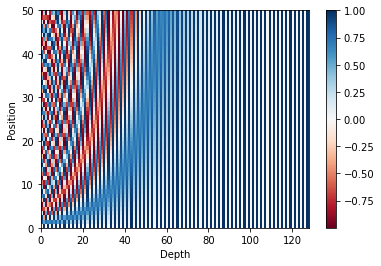

In [3]:
sample_pos_encoding = PositionalEncoding(50,128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0],cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0,128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [4]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [5]:
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                    [0,10,0],
                    [0,0,10],
                    [0,0,10]], dtype=tf.float32)
temp_v = tf.constant([[1,0],
                    [10,0],
                    [100,5],
                    [1000,6]],dtype=tf.float32)
temp_q = tf.constant([[0,10,0]],dtype=tf.float32)

In [6]:
temp_out,temp_attn = scaled_dot_product_attention(temp_q,temp_k,temp_v,None)
print(temp_attn)
print(temp_out)

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [7]:
temp_q = tf.constant([[0,0,10]],dtype=tf.float32)
temp_out,temp_attn = scaled_dot_product_attention(temp_q,temp_k,temp_v,None)
print(temp_attn)
print(temp_out)

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [8]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32) 
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) 
print(temp_out) 

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [10]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x,0),tf.float32)
    return mask[:,tf.newaxis,tf.newaxis,:]

In [11]:
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


In [12]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [13]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [14]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len,seq_len)),-1,0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask,padding_mask)

In [15]:
print(create_look_ahead_mask(tf.constant([[1,2,0,4,5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [16]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  # 패딩 마스크(두번째 서브층)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [17]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [18]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [20]:
def loss_function(y_true,y_pred):
    y_true = tf.reshape(y_true,shape=(-1,MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')(y_true,y_pred)
    mask = tf.cast(tf.not_equal(y_true,0),tf.float32)
    loss = tf.multiply(loss,mask)
    
    return tf.reduce_mean(loss)

In [21]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,d_model,warmup_steps=4000):
        super(CustomSchedule,self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model,tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self,step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) *tf.math.minimum(arg1,arg2)    

Text(0.5, 0, 'Train Step')

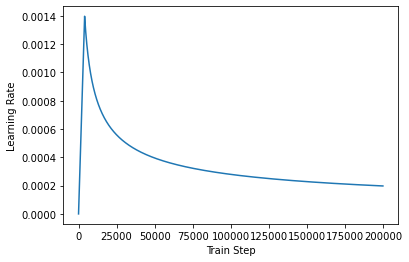

In [22]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf

In [24]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [25]:
print('챗봇 샘플의 개수 :', len(train_data))

챗봇 샘플의 개수 : 11823


In [26]:
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


In [27]:
questions = []
for sentence in train_data['Q']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [28]:
answers = []
for sentence in train_data['A']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [29]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


In [31]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers,target_vocab_size=2**13)

In [32]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size],[tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

In [33]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8178]
종료 토큰 번호 : [8179]
단어 집합의 크기 : 8180


In [34]:
print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(questions[20])))

임의의 질문 샘플을 정수 인코딩 : [5766, 611, 3509, 141, 685, 3747, 849]


In [36]:
sample_string = questions[20]

tokenized_string = tokenizer.encode(sample_string)
print('정수 인코딩 후의 문장 {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print('기존 문장 : {}'.format(original_string))

정수 인코딩 후의 문장 [5766, 611, 3509, 141, 685, 3747, 849]
기존 문장 : 가스비 비싼데 감기 걸리겠어


In [37]:
for ts in tokenized_string:
    print('{} ---> {}'.format(ts,tokenizer.decode([ts])))

5766 ---> 가스
611 ---> 비 
3509 ---> 비싼
141 ---> 데 
685 ---> 감기 
3747 ---> 걸리
849 ---> 겠어


In [38]:
MAX_LENGTH = 40
def tokenize_and_filter(inputs,outputs):
    tokenized_inputs,tokenized_outputs = [],[]
    for (sentence1,sentence2) in zip(inputs,outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs,maxlen=MAX_LENGTH,padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs,maxlen=MAX_LENGTH,padding='post')
    return tokenized_inputs,tokenized_outputs

In [39]:
questions, answers = tokenize_and_filter(questions, answers)

In [40]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 40)
답변 데이터의 크기(shape) : (11823, 40)


In [41]:
print(questions[0])
print(answers[0])

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [44]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
{
    'inputs':questions,
    'dec_inputs': answers[:,:-1]
},
{
    'outputs':answers[:,1:]
},
))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [45]:
print(answers[0])
print(answers[:1][:,:-1])
print(answers[:1][:,1:])

[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


In [46]:
tf.keras.backend.clear_session()
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1
model = transformer(
vocab_size = VOCAB_SIZE,
num_layers=NUM_LAYERS,
dff = DFF,
d_model = D_MODEL,
num_heads=NUM_HEADS,
dropout=DROPOUT)

(1, 8180, 256)
(1, 8180, 256)


In [48]:
learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate,beta_1=0.9,beta_2=0.98,epsilon=1e-9)
def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [49]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3148288     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [50]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS)

Epoch 1/50
185/185 [==============================] - 20s 68ms/step - loss: 1.4513 - accuracy: 0.0308
Epoch 2/50
185/185 [==============================] - 13s 68ms/step - loss: 1.1782 - accuracy: 0.0495
Epoch 3/50
185/185 [==============================] - 13s 71ms/step - loss: 1.0044 - accuracy: 0.0507
Epoch 4/50
185/185 [==============================] - 13s 68ms/step - loss: 0.9316 - accuracy: 0.0543
Epoch 5/50
185/185 [==============================] - 12s 67ms/step - loss: 0.8752 - accuracy: 0.0572
Epoch 6/50
185/185 [==============================] - 13s 68ms/step - loss: 0.8167 - accuracy: 0.0612
Epoch 7/50
185/185 [==============================] - 13s 69ms/step - loss: 0.7517 - accuracy: 0.0669
Epoch 8/50
185/185 [==============================] - 13s 68ms/step - loss: 0.6778 - accuracy: 0.0749
Epoch 9/50
185/185 [==============================] - 13s 70ms/step - loss: 0.5967 - accuracy: 0.0836
Epoch 10/50
185/185 [==============================] - 13s 69ms/step - loss: 0.512

In [52]:
def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

In [54]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)
    
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN,axis=0)
    output = tf.expand_dims(START_TOKEN,0)
    
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence,output],training=False)
        
        predictions = predictions[:,-1:,:]
        predicted_id = tf.cast(tf.argmax(predictions,axis=-1),tf.int32)
        
        if tf.equal(predicted_id,END_TOKEN[0]):
            break
        output = tf.concat([output,predicted_id],axis=-1)
    return tf.squeeze(output,axis=0)

In [55]:
def predict(sentence):
    prediction = evaluate(sentence)
    
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])
    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))
    
    return predicted_sentence

In [56]:
output = predict("영화 볼래?")

Input: 영화 볼래?
Output: 먼저 고백해 보세요 .


In [57]:
output = predict("고민이 있어")

Input: 고민이 있어
Output: 저는 생각을 덜하려고 노력해요 .  다른 일에 집중하거나요 .


In [58]:
output = predict("너무 화가나")

Input: 너무 화가나
Output: 그럴수록 당신이 힘들 거예요 .


In [59]:
output = predict("카페갈래?")

Input: 카페갈래?
Output: 카페 데이트 좋죠 .


In [60]:
output = predict("게임하고싶당")

Input: 게임하고싶당
Output: 그럴 때가 있어요 .


In [61]:
output = predict("게임하자")

Input: 게임하자
Output: 게임하세요 !


In [62]:
import tensorflow as tf

In [63]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [64]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

In [65]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [66]:
vocab_size = 20000  # 빈도수 상위 2만개의 단어만 사용
max_len = 200  # 문장의 최대 길이

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))

훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000


In [67]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

In [68]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [69]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_test, y_test))

print("테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/2
782/782 [==============================] - 20s 24ms/step - loss: 0.3816 - accuracy: 0.8152 - val_loss: 0.3197 - val_accuracy: 0.8718
Epoch 2/2
782/782 [==============================] - 6s 7ms/step - loss: 0.3147 - accuracy: 0.8704
테스트 정확도: 0.8704
